In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Train.csv')

# Display the first few rows to check for a column that might indicate holidays
print(df.head())


,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33745,2017-05-17 21:00:00,None,74,85,1,328,7,7,287.88,0.0,0.0,90,Mist,mist,2348
33746,2017-05-17 22:00:00,None,81,70,1,24,2,2,286.95,0.0,0.0,90,Rain,heavy intensity rain,2194
33747,2017-05-17 22:00:00,None,138,70,1,24,1,1,286.95,0.0,0.0,90,Mist,mist,2194
33748,2017-05-17 23:00:00,None,229,66,1,42,6,6,285.75,0.0,0.0,90,Rain,heavy intensity rain,1328


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Train.csv')

# Check unique values in the 'is_holiday' column
print(df['is_holiday'].unique())

# Convert any value that is not 'None' to 1 (indicating a holiday) and 'None' to 0
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Verify the conversion
print(df['is_holiday'].value_counts())


['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
0    33707
1       43
Name: is_holiday, dtype: int64


In [3]:
# Group by the 'is_holiday' column and calculate average traffic volume
average_traffic_by_holiday = df.groupby('is_holiday')['traffic_volume'].mean()
print(average_traffic_by_holiday)

is_holiday
0    3243.182395
1     838.116279
Name: traffic_volume, dtype: float64


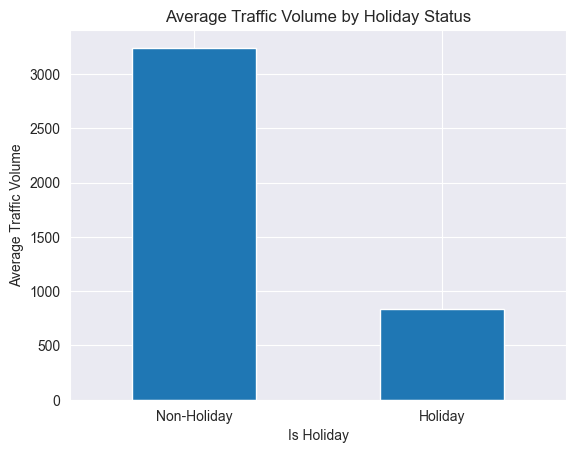

In [4]:
import matplotlib.pyplot as plt

# Plot average traffic volume by holiday status
average_traffic_by_holiday.plot(kind='bar')
plt.title('Average Traffic Volume by Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

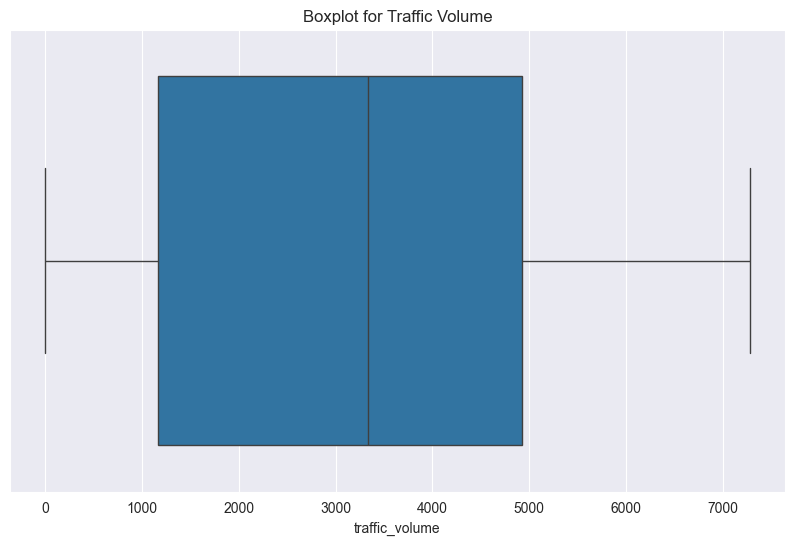

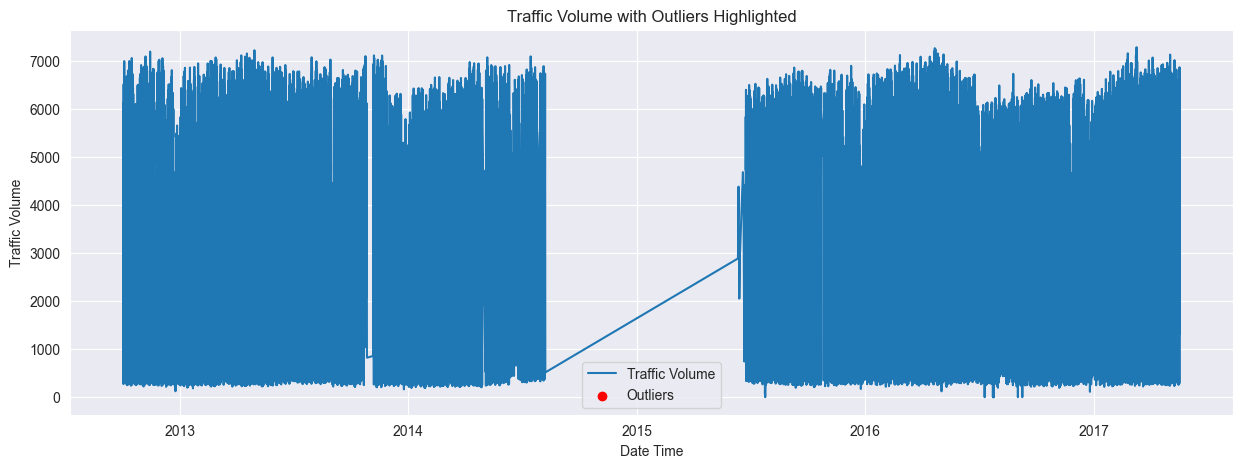

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_raw = pd.read_csv('Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Calculate IQR for outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = df[(df[target] < (Q1 - 1.5 * IQR)) | (df[target] > (Q3 + 1.5 * IQR))]

# Plot to visualize outliers using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[target])
plt.title('Boxplot for Traffic Volume')
plt.show()

# Plot a time series graph highlighting outliers
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[target], label='Traffic Volume')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers', zorder=5)
plt.title('Traffic Volume with Outliers Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

In [7]:
# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

In [ ]:

# Load the dataset
df_raw = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Convert 'is_holiday' from categorical to binary (1 for any holiday, 0 for non-holiday)
df_raw['is_holiday'] = df_raw['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Split the dataset into numerical and categorical features for scaling
X_numerical = df.drop(list(df.filter(regex='is_holiday')), axis=1)
X_categorical = df.filter(regex='is_holiday')

# Scale the numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Combine scaled numerical and categorical features
X_scaled = np.concatenate((X_numerical_scaled, X_categorical), axis=1)

# Split the data into train and test sets
total_samples = X_scaled.shape[0]
split_index = int(total_samples * 0.9)

X_train = X_scaled[:split_index]
y_train = y.iloc[:split_index]
X_test = X_scaled[split_index:]
y_test = y.iloc[split_index:]

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the TqdmRandomizedSearchCV object with the time series cross-validator
random_search = TqdmRandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1,
    random_state=42
)

# Fit the random search to the scaled data
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_
print(f"Best parameters found: {best_parameters}")

# Train the best model on the scaled data
best_model = random_search.best_estimator_

# Evaluate the model using time series cross-validation on the training data
train_rmse_list = []
train_mae_list = []
train_r2_list = []
train_mape_list = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    best_model.fit(X_train_fold, y_train_fold)
    y_pred_train_fold = best_model.predict(X_train_fold)

    rmse_train_fold = np.sqrt(mean_squared_error(y_train_fold, y_pred_train_fold))
    mae_train_fold = mean_absolute_error(y_train_fold, y_pred_train_fold)
    r2_train_fold = r2_score(y_train_fold, y_pred_train_fold)
    mape_train_fold = mape_scorer(y_train_fold, y_pred_train_fold)

    train_rmse_list.append(rmse_train_fold)
    train_mae_list.append(mae_train_fold)
    train_r2_list.append(r2_train_fold)
    train_mape_list.append(mape_train_fold)

# Print the average metrics over all folds for training data
print("Average Training Metrics:")
print(f"RMSE: {np.mean(train_rmse_list)}")
print(f"MAE: {np.mean(train_mae_list)}")
print(f"R-squared: {np.mean(train_r2_list)}")
print(f"MAPE: {np.mean(train_mape_list)}")

# Evaluate the model using metrics on the validation data
y_pred_val = best_model.predict(X_train[test_index])

# Calculate the metrics for the validation set
rmse_val = np.sqrt(mean_squared_error(y_train[test_index], y_pred_val))
mae_val = mean_absolute_error(y_train[test_index], y_pred_val)
r2_val = r2_score(y_train[test_index], y_pred_val)
mape_val = mape_scorer(y_train[test_index], y_pred_val)

# Print the metrics for the validation set
print("\nMetrics for Validation Set:")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R-squared: {r2_val}")
print(f"MAPE: {mape_val}")

In [ ]:
# Plot the results for the unseen 7 days in the validation set
comparison_val_df = pd.DataFrame({'Actual': y_train[test_index], 'Predicted': y_pred_val}, index=y_train[test_index].index)
last_7_days_val = comparison_val_df.last('7D')  # '7D' for 7 days

plt.figure(figsize=(15, 5))
plt.plot(last_7_days_val['Actual'], label='Actual (Validation)', marker='o')
plt.plot(last_7_days_val['Predicted'], label='Predicted (Validation)', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days (Validation Set)')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ...

# Print the date ranges for the last training split and the first few test splits
for i, (train_index, test_index) in enumerate(tscv.split(X_train), 1):
    train_start_date, train_end_date = df.index[train_index[0]], df.index[train_index[-1]]
    test_start_date, test_end_date = df.index[test_index[0]], df.index[test_index[-1]]
    
    print(f"Split {i}:")
    print(f"Last Training Split: {train_start_date} to {train_end_date}")
    print(f"First Test Split: {test_start_date} to {test_end_date}")
    print()

# ...


In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test.index, residuals, label='Residuals')
plt.hlines(y=0, xmin=y_test.index.min(), xmax=y_test.index.max(), color='red', linestyles='dashed', label='Zero Line')
plt.title('Residuals of Traffic Volume Predictions')
plt.xlabel('Date Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
from math import sqrt

# Lists to store the RMSE of each fold
train_rmse_list = []
val_rmse_list = []

#By using TimeSeriesSplit, you ensure that the validation data is always "unseen" to the model at the time of training.
for train_index, val_index in tscv.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Fit the model on the training fold
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train_fold, y_train_fold)

    # Predict on the training and validation fold
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)

    # Calculate RMSE for the current fold
    train_rmse = sqrt(mean_squared_error(y_train_fold, y_train_pred))
    val_rmse = sqrt(mean_squared_error(y_val_fold, y_val_pred))

    # Append to lists
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)

# Output the average RMSE across all folds
print(f"Average Train RMSE: {np.mean(train_rmse_list)}")
print(f"Average Validation RMSE: {np.mean(val_rmse_list)}")

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')

# Convert scores to positive RMSE
rmse_scores = np.sqrt(-scores)

# Plot the scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.title('Cross-Validation RMSE Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=tscv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation for train and validation scores
train_mean = np.mean(np.sqrt(-train_scores), axis=1)
train_std = np.std(np.sqrt(-train_scores), axis=1)
val_mean = np.mean(np.sqrt(-val_scores), axis=1)
val_std = np.std(np.sqrt(-val_scores), axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.show()


In [ ]:
import shap

# Assuming your best model is trained and named best_model
# and your feature matrix is named X_test_scaled

# Initialize the SHAP explainer with your model
explainer = shap.Explainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=10)

# For a global understanding, you can plot summary plots
shap.summary_plot(shap_values, X_test_scaled)

# If you want to convert scaled features back to original for better interpretability:
# Inverse transform the scaled features
X_test_unscaled = scaler.inverse_transform(X_test_scaled)

# Make a DataFrame from the unscaled features for better interpretability
X_test_unscaled_df = pd.DataFrame(X_test_unscaled, columns=X_numerical.columns)

# Compute SHAP values on the unscaled features
shap_values_unscaled = explainer(X_test_unscaled_df)

# Summary plot with unscaled features
shap.summary_plot(shap_values_unscaled, X_test_unscaled_df)


In [ ]:
import shap

# Initialize the SHAP explainer with your model
explainer = shap.Explainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

# For a global understanding, you can plot summary plots
shap.plots.beeswarm(shap_values)

# If you need to display SHAP values in a Jupyter notebook:
shap.initjs()

# Plot SHAP values for the first sample from the test set
shap.plots.force(shap_values[0])


In [ ]:
df_test.head()

In [ ]:
feature_list = df_test.columns.tolist()

# Print the list of features
print(feature_list)


In [ ]:
# Your existing code remains unchanged until after the model evaluation.

# ... [Your existing code for training and evaluating the XGBoost model]

# Import LIME packages
from lime import lime_tabular

# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=df.drop(target, axis=1).columns.tolist(),
    class_names=[target],
    mode='regression'
)

# Choose a specific instance to explain, for example, the first instance in the test set
instance_index = 0
instance = X_test_scaled[instance_index]

# Generate LIME explanation for this instance
exp = explainer.explain_instance(
    data_row=instance, 
    predict_fn=best_model.predict
)

# Display the explanation
# Note: This will work in a Jupyter Notebook to display inline.
# If you are not in a Jupyter environment, you may need to use exp.save_to_file('lime_explanation.html') instead.
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# Load the test dataset (replace 'Test.csv' with the actual file path)
df_test = pd.read_csv('Test.csv')

# Convert the 'date_time' column to datetime
df_test['date_time'] = pd.to_datetime(df_test['date_time'])

# Feature engineering: create lagged and rolling features (similar to what you did for training data)
for i in range(1, 4):
    df_test[f'traffic_volume_lag_{i}'] = df_test['traffic_volume'].shift(i)
df_test['traffic_volume_rolling_mean'] = df_test['traffic_volume'].rolling(window=3).mean().shift(1)
df_test['traffic_volume_rolling_std'] = df_test['traffic_volume'].rolling(window=3).std().shift(1)

# One-hot encode categorical features (similar to what you did for training data)
df_test = pd.get_dummies(df_test, columns=['weather_type', 'weather_description'], drop_first=True)

# Split the test dataset into numerical and categorical features for scaling
X_test_numerical = df_test.drop(list(df_test.filter(regex='is_holiday')), axis=1)
X_test_categorical = df_test.filter(regex='is_holiday')

# Load the trained scaler used for training data
scaler = joblib.load('scaler.save')

# Scale the numerical features using the same scaler used for training data
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Combine scaled numerical and categorical features
X_test_scaled = np.concatenate((X_test_numerical_scaled, X_test_categorical), axis=1)

# Load the trained XGBoost model
best_model = xgb.XGBRegressor(objective='reg:squarederror')
best_model.load_model('best_xgboost_model.json')

# Use the trained XGBoost model to make predictions on the test data
y_test_pred = best_model.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(df_test['date_time'], y_test_pred, label='Predicted', marker='x', linestyle='--')
plt.title('Predicted Traffic Volume Over Time (Test Data)')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
